# Nye aviser

In [84]:
import dhlab.nbtext as nb
import dhlab.graph_networkx_louvain as gnl
import dhlab.nbtokenizer as tok
from dhlab.module_update import css, update, code_toggle

In [85]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns


def get_df(frases, title='aftenposten', media='aviser'):
    import requests
    querystring = " OR ".join(['"'+frase+'"' for frase in frases])
    query = {
        'q':querystring,
        'size':1,
        'aggs':'year',
        'filter':['mediatype:{mt}'.format(mt=media),'title:{title}'.format(title=title)]
    }
    r = requests.get("https://api.nb.no/catalog/v1/items", params = query)
    aggs = r.json()['_embedded']['aggregations'][0]['buckets']
    return {x['key']:x['count'] for x in aggs}

def get_json(frases, mediatype='aviser', title='*'):
    import requests
    querystring = " + ".join(['"'+frase+'"' for frase in frases])
    query = {
        'q':querystring,
        'size':1,
        'snippets':mediatype,
        'aggs':'year',
        
       'filter':['mediatype:{mt}'.format(mt=mediatype),'title:{title}'.format(title=title)],
        'searchType':'FULL_TEXT_SEARCH'
        #'filter':
    }
    r = requests.get("https://api.nb.no/catalog/v1/items", params = query)
    aggs = r.json()
    return aggs

def get_data(frase, media='aviser', title='jazznytt'):
    import requests
    query = {
        'q':'"'+frase+'""',
        'size':1,
        'aggs':'year',
        'filter':['mediatype:{mt}'.format(mt=media),'title:{title}'.format(title=title)]
        
    }
    r = requests.get("https://api.nb.no/catalog/v1/items", params = query)
    return r.json()

def get_data_and(frases, title='aftenposten', media='aviser'):
    import requests
    querystring = " + ".join(['"'+frase+'"' for frase in frases])
    print(querystring)
    query = {
        'q':querystring,
        'size':1,
        'aggs':'year',
        'filter':['mediatype:{mt}'.format(mt=media), 'title:{title}'.format(title=title)],
        #'filter':'title:{title}'.format(title=title)
    }
    r = requests.get("https://api.nb.no/catalog/v1/items", params = query)
    return r.json()

def get_df_pd(frase, media='bøker'):
    import pandas as pd
    return pd.DataFrame.from_dict(get_df(frase, media=media ), orient='index').sort_index()

def phrase_plots(phrase_sets, title='aftenposten', fra = 1960, til = 2020, step=5, rot=0, colours = ['r', 'b','g','y','m','c']):
    df_all = []
    for f in phrase_sets:
        df_all.append(nb.frame(get_df(f, title= title), ', '.join(f)))
    df = pd.concat(df_all, sort=False)
    df.index = df.index.astype(int)
    df = df.sort_index()
    df['bins'] = pd.cut(df.index, range(fra, til, step), precision = 0)
    df.groupby('bins').sum().plot(kind='bar', color=colours, figsize=(15,5), rot=rot)
    return

def phrase_plots_anno(phrase_sets, title='aftenposten', fra = 1960, til = 2020, rot=0, colours = ['r', 'b','g']):
    df_all = []
    for f in phrase_sets:
        df_all.append(nb.frame(get_df(f, title= title), ', '.join(f)))
    df = pd.concat(df_all, sort=False)
    df.index = df.index.astype(int)
    df = df.sort_index()
    #df['bins'] = pd.cut(df.index, range(fra, til, step), precision=0)
    df.plot(kind='bar', figsize=(15,5), rot=rot, color=colours)
    return

def graph_from_df(df, threshold = 100):
    edges =  []
    normalizer = {(x, y): df.stack()[(x,x)]*df.stack()[(y,y)] for (x,y) in df.stack().index}
    for (x, y) in df.stack().index:
        if x != y:
            if df.stack()[(x,y)] > threshold:
                edges.append([x,y,df.stack()[(x,y)]/normalizer[(x,y)]])
    G = nx.Graph()
    G.add_weighted_edges_from(edges)
    return G

def super_search(title, number=50, page=0, mediatype='aviser', period = (18000101, 20401231)):
    """Søk etter term og få ut json"""
    number = min(number, 50)
    r = requests.get(
        "https://api.nb.no:443/catalog/v1/items", 
         params = { 
             'filter':[
                 'mediatype:{mediatype}'.format(mediatype=mediatype),
                 'title:{title}'.format(title=title),
                 'date:[{date_from} TO {date_to}]'.format(date_from = period[0], date_to = period[1])
             ],
             'page':page, 
             'size':number
         }
    )
    return r.json()

def get_df_level(frases, title='*', coord = 'OR', media='aviser', period = (18000101, 20401231)):
    """Get dokument frequencies for phrases, coordinated with coord OR AND or +"""
    import requests
    coord = " " + coord + " "
    querystring = coord.join(['"'+frase+'"' for frase in frases])
    if media == 'bøker':
        agg_level = 'year'
    elif media == 'tidsskrift':
        agg_level = 'year,month'
    else:
        agg_level = 'year,month,day'
    query = {
        'q':querystring,
        'size':1,
        'aggs':agg_level,
        'filter':[
            'mediatype:{mt}'.format(mt=media),
            'title:{title}'.format(title=title),
            'date:[{date_from} TO {date_to}]'.format(date_from = period[0], date_to = period[1])
        ]
        
    }
    r = requests.get("https://api.nb.no/catalog/v1/aggregations", params = query)
    aggs = r.json()['_embedded']['aggregations'][0]['buckets']
    df = create_frame_from_bucket(aggs) #{x['key']:x['count'] for x in aggs}
    df.columns = [querystring]
    return df

def phrase_plots_level(phrase_set, title='*', period=(20100101, 20301231), media='aviser'):
    df_all = [nb.frame(get_df_level(f, title = title, period = period, media=media), ', '.join(f)) for f in phrase_set]
    df = pd.concat(df_all, sort=False, axis=1)
    return df



def term_urn_search(term, number=50, page=0, mediatype='aviser', period=(18000101, 20401231)):
    """Søk etter term og få ut json"""
    number = min(number, 50)
    #print(period)
    r = requests.get(
        "https://api.nb.no:443/catalog/v1/search", 
         params = { 
             'q':term,
             'sort':'date,desc',
            
             'filter':[
                 'mediatype:{mediatype}'.format(mediatype=mediatype),
                 'date:[{date_from} TO {date_to}]'.format(date_from = period[0], date_to = period[1] )
             ],
             'page':page, 
             'size':number,
             'random':'true'
         }
    )
    res = r.json()
    tot = res['totalElements']
    if tot > 0:
        result = res['_embedded']['mediaTypeResults'][0]['result']['_embedded']['items']
        urns = [r['metadata']['identifiers']['urn'] for r in result]
    else:
        urns = []
    return tot, urns

def term_docs(term, number=50, page=0, mediatype='aviser', period=(18000101, 20401231)):
    """Søk etter term og få ut json"""
    number = min(number, 50)
    #print(period)
    r = requests.get(
        "https://api.nb.no:443/catalog/v1/search", 
         params = { 
             'q':term,
             'sort':'date,desc',
            
             'filter':[
                 'mediatype:{mediatype}'.format(mediatype=mediatype),
                 'date:[{date_from} TO {date_to}]'.format(date_from = period[0], date_to = period[1] )
             ],
             'page':page, 
             'size':number,
             'random':'true'
         }
    )
    res = r.json()
    tot = res['totalElements']
    if tot > 0:
        result = res['_embedded']['mediaTypeResults'][0]['result']['_embedded']['items']
        urns = [r['metadata']['identifiers']['urn'] for r in result]
    else:
        urns = []
    return tot, urns

def get_konks(urn, phrase, window=1000, n = 1000):
    import requests
    querystring = '"'+ phrase +'"' 
    query = {
        'q':querystring,
        'fragments': n,
        'fragSize':window
       
    }
    r = requests.get("https://api.nb.no/catalog/v1/items/{urn}/contentfragments".format(urn=urn), params = query)
    res = r.json()
    results = []
    try:
        for x in res['contentFragments']:
            urn = x['pageid']
            hit = x['text']
            splits = hit.split('<em>')
            s2 = splits[1].split('</em>')
            before = splits[0]
            word = s2[0]
            after = s2[1]
            results.append({'urn': urn, 'before': before, 'word':word, 'after':after})
    except:
        True
    return results

def get_phrase_info(urn, phrase, window=1000, n = 1000):
    import requests
    querystring = '"'+ phrase +'"' 
    query = {
        'q':querystring,
       
    }
    r = requests.get("https://api.nb.no/catalog/v1/items/{urn}/contentfragments".format(urn=urn), params = query)
    res = r.json()
    return res

def get_all_konks(term, urns):
    konks = []
    for u in urns:
        konks += get_konks(u, term)
    return konks

Estimer antallet av et ord i aviser

In [396]:
dfs = phrase_plots_level([['korona*','corona*'],['karantene*']], period=(20191130,20200530))

In [427]:
dfs = phrase_plots_level([['moren'],['faren']], media='bøker', period=(20091130,20200530))

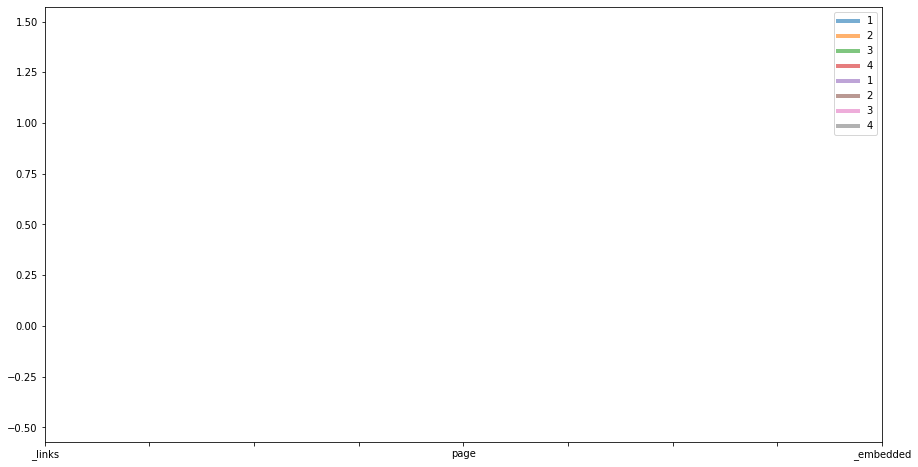

In [428]:
dfs.rolling(window=3).mean().plot(figsize=(15,8), lw=4, alpha=.6)

In [405]:
dfs = phrase_plots_level([['korona*'],['karantene*']], period=(20191130,20200530))

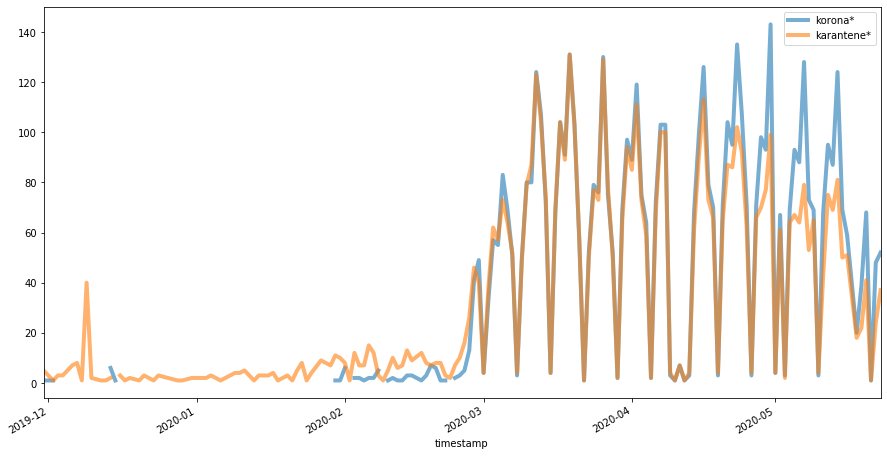

In [406]:
dfs.plot(figsize=(15,8), lw=4, alpha=.6)

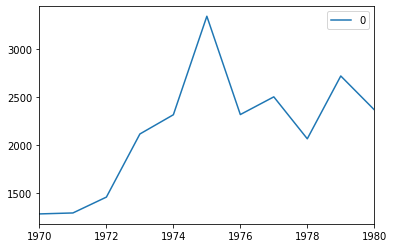

In [319]:
nb.unigram('likestilling', period=(1970, 1980), media='avis').plot()

In [524]:
def document_frequency(frases, title='*', coord = 'OR', media='aviser', period = (18000101, 20401231)):
    """Get dokument frequencies for phrases, coordinated with coord OR AND or +"""
    import requests
    coord = " " + coord + " "
    querystring = coord.join(['"'+frase+'"' for frase in frases])
    if media == 'bøker':
        agg_level = 'year'
    elif media == 'tidsskrift':
        agg_level = 'year,month'
    else:
        agg_level = 'year,month,day'
    query = {
        'q':querystring,
        'size':1,
        'aggs':agg_level,
        'filter':[
            'mediatype:{mt}'.format(mt=media),
            'title:{title}'.format(title=title),
            'date:[{date_from} TO {date_to}]'.format(date_from = period[0], date_to = period[1])
        ]
        
    }
    r = requests.get("https://api.nb.no/catalog/v1/aggregations", params = query)
    aggs = r.json()['_embedded']['aggregations'][0]['buckets']
    df = create_frame_from_bucket(aggs, agg_level.split(',')) #{x['key']:x['count'] for x in aggs}
    df.columns = [querystring]
    return df

In [525]:
def create_frame_from_bucket(bucket, agg_levels):
    rows=[]
    
    for year in bucket:
        if 'month' in agg_levels and 'buckets' in year["aggregations"][0]:
            for month in year["aggregations"][0]["buckets"]:
                if 'day' in agg_levels and 'buckets' in month['aggregations'][0]:
                    for day in month['aggregations'][0]['buckets']:
                        rows.append([year['key'], month['key'], day['key'], day['count']])
                else:
                    rows.append([year['key'], month['key'], '01', month['count']])
        else:
            rows.append([year['key'], '01','01',year['count']])
                            
    df = pd.DataFrame(rows)
    df.columns = ['year','month','day','count']
    for level in ['year', 'month', 'day']:
        df[level] = pd.to_numeric(df[level])
    df = df[['year', 'month','day', 'count']]
    df["timestamp"] = pd.to_datetime(df[['year','month','day']])
    df = df[["timestamp", "count"]]
    df = df.set_index('timestamp')
    
    return df

In [533]:
a = document_frequency(['aviser','bøker','journaler','ukeblad'], coord='AND', media='tidsskrift', period=(19500101, 20000101))

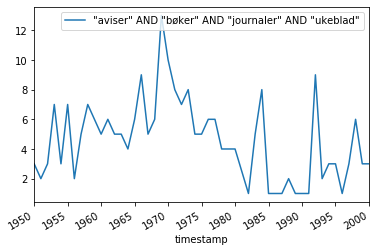

In [534]:
a.plot()

In [543]:
sample_urn = term_urn_search(['hallo i uken'])[1][0]

In [546]:
get_phrase_info(sample_urn, 'hallo')

{'_links': {'self': {'href': 'https://api.nb.no/catalog/v1/items/URN:NBN:no-nb_digavis_verdensgang_null_null_19840820_40_191_1/contentfragments?q=%22hallo%22&fragments=1000&fragSize=1000'}}}